In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve,roc_auc_score, precision_recall_curve, confusion_matrix
from sklearn.model_selection import StratifiedKFold

from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras.models import load_model

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Using TensorFlow backend.


/kaggle/input/last-icustay/last_icustay_20200614.csv
/kaggle/input/optimized-model/optimized_model.h5
/kaggle/input/severity-features/sapsii_processed.csv
/kaggle/input/severity-features/saps_processed.csv
/kaggle/input/severity-features/sofa_processed.csv
/kaggle/input/severity-features/oasis_processed.csv


In [2]:
#Load the data

#severity scores features
sofa = pd.read_csv(r'/kaggle/input/severity-features/sofa_processed.csv', index_col = 'icustay_id')
oasis = pd.read_csv(r'/kaggle/input/severity-features/oasis_processed.csv', index_col = 'icustay_id')
saps = pd.read_csv(r'/kaggle/input/severity-features/saps_processed.csv', index_col = 'icustay_id')
sapsii = pd.read_csv(r'/kaggle/input/severity-features/sapsii_processed.csv', index_col = 'icustay_id')
last_icustay = pd.read_csv(r'/kaggle/input/last-icustay/last_icustay_20200614.csv', index_col = 'icustay_id')

#dictionary with the severity scores dataframes
severity = {'sofa': sofa, 'oasis': oasis, 'saps': saps, 'sapsii': sapsii}

In [3]:
for key in severity:
    severity[key] = severity[key].loc[severity[key].index.isin(last_icustay.index)]
    if key == 'sofa':
        full_features = severity[key]
    else:
        full_features = pd.concat([full_features, \
                        severity[key][severity[key].columns[~severity[key].columns.isin(full_features.columns)]]], axis=1)

severity = {'full features': full_features}

In [4]:
def create_model(input_dim = 0, dropout = 0.2, optimizer = 'Adam', \
                    nodes_hidden_1 = 50, nodes_hidden_2 = 25):
    model = Sequential()

    model.add(Dense(nodes_hidden_1, activation = 'relu', input_dim = input_dim, \
                        kernel_initializer='random_uniform', bias_initializer='zeros'))
    model.add(Dropout(dropout))
    
    model.add(Dense(nodes_hidden_2, activation = 'relu', \
                        kernel_initializer='random_uniform', bias_initializer='zeros'))
    model.add(Dropout(dropout))

    model.add(Dense(2, activation = 'softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [5]:
#Over-Sampling with SMOTE
def oversampling(X, y):
    smote = SMOTE()
    X_sm, y_sm = smote.fit_sample(X, y)
    return X_sm, y_sm

def undersampling(X, y):
    rus = RandomUnderSampler()
    X_rus, y_rus = rus.fit_sample(X, y)
    return X_rus, y_rus

In [6]:
#Plot Functions
def plot_roc_folds(fpr, tpr, i = 0): 
  plt.plot(fpr,tpr, label = 'ROC fold {}'.format(i+1), alpha = 0.5) 
  plt.axis([0,1.01,0,1.01]) 
  plt.title('ROC Curve')
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  plt.legend(loc = 'best')

def plot_precision_recall_folds(precision, recall, i = 0): 
  plt.plot(recall,precision, label = 'Pre-Rec fold {}'.format(i+1), alpha = 0.5) 
  plt.axis([0,1.01,0,1.01])
  plt.title('Precision-Recall Curve')
  plt.xlabel('Recall') 
  plt.ylabel('Precision') 
  plt.legend(loc = 'best')

def plot_roc_mean(base_fpr, tprs, aucs):
    aucs = np.array(aucs)
    auc_mean, auc_std = aucs.mean(axis=0), aucs.std(axis=0)
    tprs = np.array(tprs)
    mean_tpr, std_tpr = tprs.mean(axis=0), tprs.std(axis=0)

    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

    plt.figure(figsize=(5, 5))

    plt.plot(base_fpr, mean_tpr, 'b', label=r'Mean ROC')
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.title('ROC Curve')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.axes().set_aspect('equal', 'datalim')
    plt.legend(loc = 'best')
    
def plot_precision_recall_mean(base_recall, pre_rec):
    pre_rec = np.array(pre_rec)
    mean_pre_rec, std_pre_rec = pre_rec.mean(axis=0), pre_rec.std(axis=0)

    pre_rec_upper = np.minimum(mean_pre_rec + std_pre_rec, 1)
    pre_rec_lower = np.maximum(mean_pre_rec - std_pre_rec, 0)

    plt.figure(figsize=(5, 5))

    plt.plot(base_recall, mean_pre_rec, 'b', label=r'Mean Precision-Recall')
    plt.fill_between(base_recall, pre_rec_lower, pre_rec_upper, color='grey', alpha=0.3)

    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.title('Precision-Recall Curve')
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.axes().set_aspect('equal', 'datalim')
    plt.legend(loc = 'best')
    
def plot_loss_folds(hist):
    for i in hist:
        plt.plot(hist[i].history['loss'], label = 'Loss fold {}'.format(i+1), alpha = 0.5)
    plt.title('Training Loss')
    plt.ylabel('Cross Entropy')
    plt.xlabel('epoch')
    plt.legend(loc = 'best')

In [7]:
def load_optimized_model():
    model = load_model(r'/kaggle/input/optimized-model/optimized_model.h5')
    return model   

AUC-ROC 0.9262398919839212
AUC-ROC 0.9598113484123708
AUC-ROC 0.9668371292206508
AUC-ROC 0.9674936423554285
AUC-ROC 0.9642232842346881
AUC-ROC 0.9687066280672882
AUC-ROC 0.9693951499921784
AUC-ROC 0.9669076597499624
AUC-ROC 0.9697688380482663
AUC-ROC 0.9663085961897463


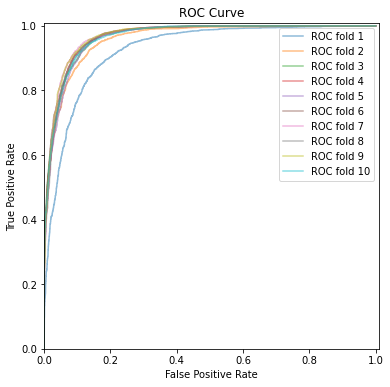

In [8]:
cv = StratifiedKFold(n_splits=10)

X, y = severity['full features'].drop(columns = ['clase']), severity['full features']['clase']
X, y = oversampling(X, y)
#X, y = undersampling(X, y)

params = {'input_dim': len(X.values[0]), 'optimizer': 'Adam', 'dropout': 0.2, \
                 'hidden_1': 60, 'hidden_2': 35}

tprs = []
pre_rec = []
base_fpr = np.linspace(0, 1, 101)
base_recall = np.linspace(0, 1, 101)
aucs = [] 
hist = {}
precision_recall = []
confusion = []

plt.figure(figsize=(6, 6))

for i, (train, test) in enumerate(cv.split(X, y)):
    model = KerasClassifier(build_fn = create_model, input_dim = params['input_dim'], \
                            dropout = params['dropout'], optimizer = params['optimizer'], \
                            nodes_hidden_1 = params['hidden_1'], nodes_hidden_2 = params['hidden_2'], \
                            batch_size = 100, epochs = 150, verbose = 0)
    
    history = model.fit(X.iloc[train], to_categorical(y.iloc[train]))
    
    y_pred_conf = model.predict(X.iloc[test])
    y_pred = model.predict_proba(X.iloc[test])
    y_proba = [a[1] for a in y_pred]
    
    tn, fp, fn, tp = confusion_matrix(y.iloc[test],y_pred_conf).ravel()
    confusion.append([tn, fp, fn, tp])
    
    fpr, tpr, thresholds = roc_curve(y.iloc[test], y_proba)
    plot_roc_folds(fpr, tpr, i)
    
    precision, recall, thresholds = precision_recall_curve(y.iloc[test], y_proba)
    precision_recall.append([precision, recall])
    
    auc_roc = roc_auc_score(y.iloc[test],y_proba)
    print('AUC-ROC', auc_roc)
    aucs.append(auc_roc)
    
    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs.append(tpr)
    
    a = np.interp(base_recall, precision, recall)
    a[0] = 1
    pre_rec.append(a)
    
    hist[i] = history

plt.savefig('kfolds_roc_final_model.png')
plt.show()

In [9]:
cm = {'True Negative': 0, 'False Positive': 0, 'False Negative': 0, 'True Positive': 0}

i = 0
for key in cm:
    for j in confusion:
        cm[key] += j[i]
    i += 1

print(cm)

{'True Negative': 27961, 'False Positive': 4301, 'False Negative': 2132, 'True Positive': 30130}


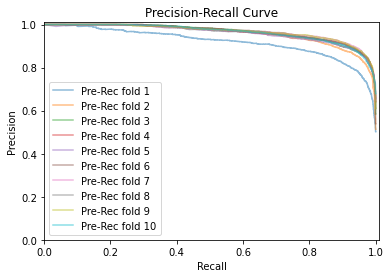

In [10]:
for i in range(len(precision_recall)):
    plot_precision_recall_folds(precision_recall[i][0], precision_recall[i][1], i)
    
plt.savefig('kfolds_precision_recall_final_model.png')
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


<Figure size 432x432 with 0 Axes>

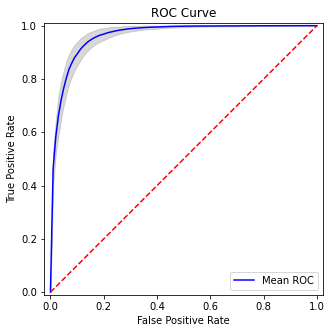

In [11]:
#mean ROC
plt.figure(figsize=(6, 6))
plot_roc_mean(base_fpr, tprs, aucs)
plt.savefig('mean_roc_final_model.png')
plt.show()

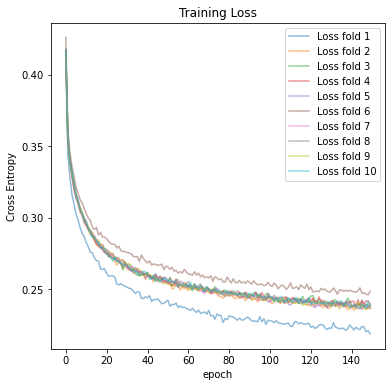

In [12]:
plt.figure(figsize=(6, 6))
plot_loss_folds(hist)
plt.savefig('kfolds_loss_final_model.png')
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


<Figure size 432x432 with 0 Axes>

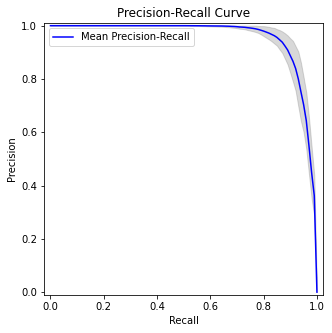

In [13]:
#mean Precision-Recall Curve
plt.figure(figsize=(6, 6))
plot_precision_recall_mean(base_recall, pre_rec)
plt.savefig('mean_precision_recall_final_model.png')
plt.show()